In [1]:
pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 13.8 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.2-py2.py3-none-any.whl size=281824028 sha256=2b9b584edb7d3d606ce3033450249bca8e753a3a3f270a5eef1ce8cd0e415389
  Stored in directory: /root/.cache/pip/wheels/6c/e3/9b/0525ce8a69478916513509d43693511463c6468db0de237c86
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7


In [2]:
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, TimestampType, BooleanType, FloatType, DoubleType

conf = SparkConf().setAppName("crime_investigators").setMaster("local")
spark = SparkSession.builder.config(conf=conf).getOrCreate()
schema = StructType([
    StructField("ID", IntegerType(), True),
    StructField("Case Number", StringType(), True),
    StructField("Date", StringType(), True),
    StructField("Block", StringType(), True),
    StructField("IUCR", StringType(), True),
    StructField("PrimaryType", StringType(), True),
    StructField("Description", StringType(), True),
    StructField("Location Description", StringType(), True),
    StructField("Arrest", StringType(), True),
    StructField("Domestic", StringType(), True),
    StructField("Beat", IntegerType(), True),
    StructField("District", IntegerType(), True),
    StructField("Ward", IntegerType(), True),
    StructField("Community Area", IntegerType(), True),
    StructField("FBI Code", StringType(), True),
    StructField("X Coordinate", DoubleType(), True),
    StructField("Y Coordinate", DoubleType(), True),
    StructField("Year", IntegerType(), True),
    StructField("Updated On", StringType(), True),
    StructField("Latitude", DoubleType(), True),
    StructField("Longitude", DoubleType(), True),
    StructField("Location", StringType(), True),
])



In [3]:
# Load data
crime_data = spark.read.format("csv") \
                    .option("header", True) \
                    .schema(schema) \
                    .load("/content/Crimes_-_2001_to_Present.csv")

In [4]:
# Clean data
from pyspark.sql.functions import to_timestamp, col, year
from pyspark.sql.types import DateType
# filter the data for last ten years and remove specific crime reports
crime_data = crime_data.na.drop()
crime_data = crime_data.withColumn("Date", to_timestamp("Date", "MM/dd/yyyy hh:mm:ss a"))
crime_data = crime_data.withColumn("Date", to_timestamp(col("Date"), "MM/dd/yyyy hh:mm:ss a").cast(DateType()))
crime_data = crime_data.filter(year("Date") >= 2012)
crime_data = crime_data.filter(~crime_data.PrimaryType.isin(['NON-CRIMINAL (SUBJECT SPECIFIED)', 'OTHER OFFENSE', 'STALKING', 'NON - CRIMINAL', 'ARSON']))


In [5]:
# Merge similar crime types
from pyspark.sql.functions import to_timestamp, col, year, when
crime_data = crime_data.withColumn("PrimaryType", \
              when(col("PrimaryType").isin(["SEX OFFENSE", "PROSTITUTION"]), "SEX CRIMES") \
             .when(col("PrimaryType").isin(["BATTERY", "ASSAULT"]), "ASSAULT/BATTERY") \
             .when(col("PrimaryType").isin(["CRIMINAL DAMAGE", "VANDALISM"]), "DAMAGE") \
             .otherwise(col("PrimaryType")))

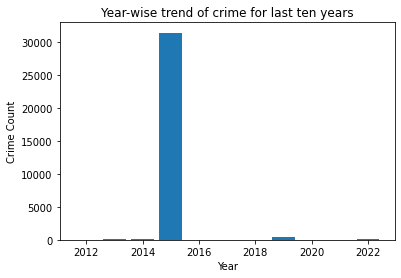

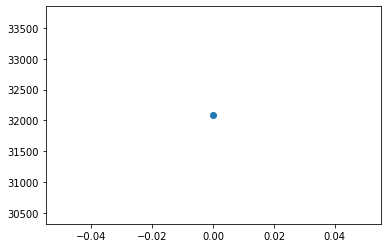

In [13]:
# ploting the year-wise trend of the crime for last ten years
import matplotlib.pyplot as plt
from pyspark.sql.functions import hour

yearly_crime_count = crime_data.groupBy('Year').count()
yearly_crime_count = yearly_crime_count.orderBy('Year')
yearly_crime_count_df = yearly_crime_count.toPandas()
plt.bar(yearly_crime_count_df['Year'], yearly_crime_count_df['count'])
plt.xlabel('Year')
plt.ylabel('Crime Count')
plt.title('Year-wise trend of crime for last ten years')
plt.show()


# Create a scatter plot for showing that which hour of the day crime is highest

hourly_crime_count = crime_data.groupBy(hour('Date').alias('Hour')).count()
hourly_crime_count = hourly_crime_count.orderBy('count', ascending=False)
hourly_crime_count_df = hourly_crime_count.toPandas()

plt.scatter(hourly_crime_count_df['Hour'], hourly_crime_count_df['count'])



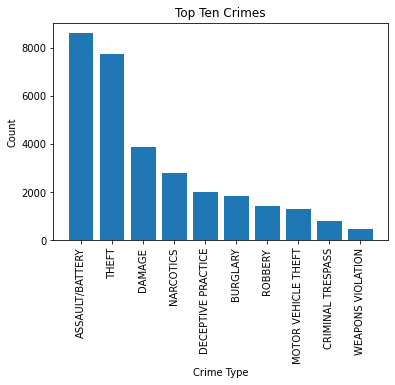

In [7]:
# Creating a bar chart of the top ten crimes

import matplotlib.pyplot as plt
import pandas as pd


crime_count = crime_data.groupBy('PrimaryType').count()
top_ten_crimes = crime_count.orderBy('count', ascending=False).limit(10)
top_ten_crimes_df = top_ten_crimes.toPandas()
plt.bar(top_ten_crimes_df['PrimaryType'], top_ten_crimes_df['count'])
plt.xticks(rotation=90)
plt.xlabel('Crime Type')
plt.ylabel('Count')
plt.title('Top Ten Crimes')
plt.show()
